# <center> SubTask A: Question Classification </center>

This subtask focuses on classifying the given questions into 3 categories : Factual, Opinion and Socializing.

A Large number of users use Community Question Answering (cQA) forums in their day to day life. There are a lot of genuine users, a lot of users who are just scammers and there are also a lot of bot accounts available in such forums. Practically there are high chances that a question posed by a genuine user might be factual and less so for bot or scam accounts. Even the length of a question might be useful in determining whether a question is actually factual or not.

This notebook implements the solution proposed by Syed (<i>Bakhtiyar Syed, Vijayasaradhi Indurthi, “Fermi at
semeval-2019 task 8: An elementary but effective approach to question discernment
in community qa forums”</i>) which was the winning solution in the competition. Then the user and length information of each question is added to the dataset to check whether those factors are in fact helpful in determining its factuality.

### Importing required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler

### Loading Data

All the required data from the xml files have been extracted and converted into a csv file for easy access.

In [2]:
train = pd.read_csv('Questions_Train.csv')
cv = pd.read_csv('Questions_Dev.csv')
test = pd.read_csv('Questions_Test.csv')

In [3]:
train.head()

,Thread Sequence,Question ID,Question Category,Question Subject,Question Body,Label,UserID
0,Q1_R1,Q1_R1,Qatar Living Lounge,massage oil,is there any place i can find scented massage ...,Factual,U1
1,Q1_R6,Q1_R6,Advice and Help,Philipino Massage center,Hi;Can any one tell me a place where i can hav...,Opinion,U5
2,Q1_R8,Q1_R8,Qatar Living Lounge,Best place for massage,Tell me; where is the best place to go for a m...,Opinion,U13
3,Q1_R10,Q1_R10,Qatar Living Lounge,body massage,hi there; i can see a lot of massage center he...,Opinion,U18
4,Q1_R22,Q1_R22,Qatar Living Lounge,What attracts you more ?,What attracts you more ?,Opinion,U26


### Dropping Null Rows from the Data

In [4]:
cv.dropna(inplace = True)
test.dropna(inplace = True)
train.dropna(inplace = True)

In [5]:
def calc_char(x):
    '''Function to calculate the length of each question'''
    return len(x.split())

train['Sentence_Length'] = train['Question Body'].apply(lambda x: calc_char(x))
cv['Sentence_Length'] = cv['Question Body'].apply(lambda x: calc_char(x))
test['Sentence_Length'] = test['Question Body'].apply(lambda x: calc_char(x))

In [6]:
# Mapping Label Values

label_mapper = {'Factual':1, 'Opinion':0, 'Socializing':2}

train['Label'] = train['Label'].map(label_mapper)
cv['Label'] = cv['Label'].map(label_mapper)
test['Label'] = test['Label'].map(label_mapper)

In [7]:
train.head()

,Thread Sequence,Question ID,Question Category,Question Subject,Question Body,Label,UserID,Sentence_Length
0,Q1_R1,Q1_R1,Qatar Living Lounge,massage oil,is there any place i can find scented massage ...,1,U1,12
1,Q1_R6,Q1_R6,Advice and Help,Philipino Massage center,Hi;Can any one tell me a place where i can hav...,0,U5,42
2,Q1_R8,Q1_R8,Qatar Living Lounge,Best place for massage,Tell me; where is the best place to go for a m...,0,U13,37
3,Q1_R10,Q1_R10,Qatar Living Lounge,body massage,hi there; i can see a lot of massage center he...,0,U18,34
4,Q1_R22,Q1_R22,Qatar Living Lounge,What attracts you more ?,What attracts you more ?,0,U26,5


### Standard Scaling Sentence Length

In [8]:
ss = StandardScaler()

train['Sentence_Length'] = ss.fit_transform(train['Sentence_Length'].values.reshape(-1, 1))
cv['Sentence_Length'] = ss.transform(cv['Sentence_Length'].values.reshape(-1, 1))
test['Sentence_Length'] = ss.transform(test['Sentence_Length'].values.reshape(-1, 1))

### Target Encoding User Information

In [9]:
woe = TargetEncoder()

train_te_users = woe.fit_transform(train['UserID'], train['Label'])
cv_te_users = woe.transform(cv['UserID'])
test_te_users = woe.transform(test['UserID'])

### Loading Universal Sentence Encoder

In [10]:
# downloaded from https://tfhub.dev/google/universal-sentence-encoder/4

m = hub.load('Universal_Sentence_Encoder\\Transformer_Encoder\\')

In [11]:
def embed(input_):
    '''Function that outputs embeddings for passed text input'''
    return m(input_)

### Extracting Embeddings using Universal Sentence Encoder

In [12]:
use_train = embed(train['Question Body'].values)
use_train = np.array(use_train)

use_cv = embed(cv['Question Body'].values)
use_cv = np.array(use_cv)

use_test = embed(test['Question Body'].values)
use_test = np.array(use_test)

### Training an XGBoost Classifier on the Extracted Features (512 dimensional features)

In [135]:
xgb_params = {}
xgb_params['n_estimators'] = 900
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 3
xgb_params['min_child_weight'] = 20

In [136]:
xgb_ = xgb.XGBClassifier(**xgb_params)
xgb_.fit(use_train, train['Label'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [137]:
# predictions for each set

train_pred = xgb_.predict(use_train)
cv_pred = xgb_.predict(use_cv)
test_pred = xgb_.predict(use_test)

In [138]:
#'Factual':1, 'Opinion':0, 'Socializing':2

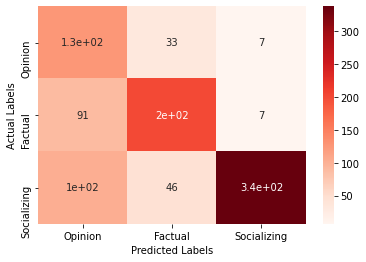

In [140]:
sns.heatmap(confusion_matrix(test['Label'], test_pred), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])

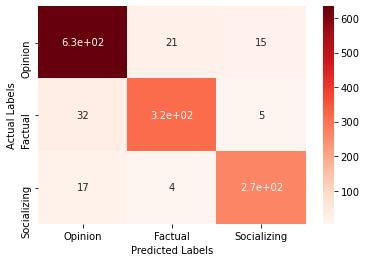

In [139]:
sns.heatmap(confusion_matrix(cv['Label'], cv_pred), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])

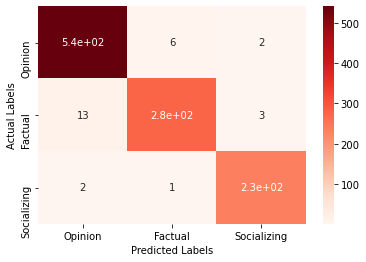

In [141]:
sns.heatmap(confusion_matrix(train['Label'], train_pred), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])

In [142]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Label'], train_pred)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Label'], cv_pred)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Label'], test_pred)*100, 2), "%")

Train Set Accuracy:  97.5 %
Dev Set Accuracy:  92.82 %
Test Set Accuracy:  69.88 %


In [143]:
print("Train Set F1-Score: ",np.round(f1_score(train['Label'], train_pred, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Label'], cv_pred, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Label'], test_pred, average='macro'), 2))

Train Set F1-Score:  0.97
Dev Set F1-Score:  0.93
Test Set F1-Score:  0.67


The above trained model(hyper-parameter tuned) gives the best result for all three datasets.

<b>Syed reports an Accuracy of 84% and 0.72 on the development set. The above model is an improvement on the results reported!!</b>

### Checking whether adding User Info improves model performance

In [23]:
# adding user info to the extracted features

train_with_users = np.hstack((use_train, train_te_users))
cv_with_users = np.hstack((use_cv, cv_te_users))
test_with_users = np.hstack((use_test, test_te_users))

In [144]:
xgb_params = {}
xgb_params['n_estimators'] = 900
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 3
xgb_params['min_child_weight'] = 50

xgb_ = xgb.XGBClassifier(**xgb_params)
xgb_.fit(train_with_users, train['Label'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [145]:
train_pred = xgb_.predict(train_with_users)
cv_pred = xgb_.predict(cv_with_users)
test_pred = xgb_.predict(test_with_users)

In [146]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Label'], train_pred)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Label'], cv_pred)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Label'], test_pred)*100, 2), "%")

Train Set Accuracy:  91.03 %
Dev Set Accuracy:  86.95 %
Test Set Accuracy:  68.42 %


In [147]:
print("Train Set F1-Score: ",np.round(f1_score(train['Label'], train_pred, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Label'], cv_pred, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Label'], test_pred, average='macro'), 2))

Train Set F1-Score:  0.91
Dev Set F1-Score:  0.86
Test Set F1-Score:  0.66


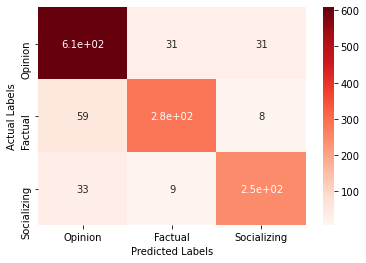

In [148]:
sns.heatmap(confusion_matrix(cv['Label'], cv_pred), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])

<b>Adding user info has decreased the accuracy in all datasets. The dataset contains 880 unique users. Maybe there is not enough data or info about the users to confirm that it affects the model performance.</b>

### Checking Whether Length of Questions improves the performance or not

In [ ]:
# adding length to the extracted features

train_with_len = np.hstack((use_train, train['Sentence_Length'].values.reshape(-1, 1)))
cv_with_len = np.hstack((use_cv, cv['Sentence_Length'].values.reshape(-1, 1)))
test_with_len = np.hstack((use_test, test['Sentence_Length'].values.reshape(-1, 1)))

In [149]:
xgb_params = {}
xgb_params['n_estimators'] = 900
xgb_params['learning_rate'] = 0.01
xgb_params['max_depth'] = 3
xgb_params['min_child_weight'] = 50

xgb_ = xgb.XGBClassifier(**xgb_params)
xgb_.fit(train_with_len, train['Label'])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=900, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [150]:
train_pred = xgb_.predict(train_with_users)
cv_pred = xgb_.predict(cv_with_users)
test_pred = xgb_.predict(test_with_users)

In [151]:
print("Train Set Accuracy: ",np.round(accuracy_score(train['Label'], train_pred)*100, 2), "%")
print("Dev Set Accuracy: ",np.round(accuracy_score(cv['Label'], cv_pred)*100, 2), "%")
print("Test Set Accuracy: ",np.round(accuracy_score(test['Label'], test_pred)*100, 2), "%")

Train Set Accuracy:  90.93 %
Dev Set Accuracy:  86.87 %
Test Set Accuracy:  68.42 %


In [152]:
print("Train Set F1-Score: ",np.round(f1_score(train['Label'], train_pred, average='macro'), 2))
print("Dev Set F1-Score: ",np.round(f1_score(cv['Label'], cv_pred, average='macro'), 2))
print("Test Set F1-Score: ",np.round(f1_score(test['Label'], test_pred, average='macro'), 2))

Train Set F1-Score:  0.91
Dev Set F1-Score:  0.86
Test Set F1-Score:  0.66


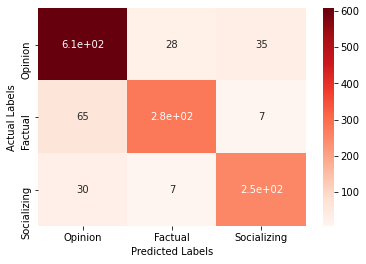

In [153]:
sns.heatmap(confusion_matrix(cv['Label'], cv_pred), cmap = 'Reds', annot =  True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
te = plt.xticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])
te = plt.yticks(ticks = [0.5,1.5,2.5], labels = ['Opinion', 'Factual', 'Socializing'])

The additional factors added doesn't seem to improve the result!!